<a href="https://colab.research.google.com/github/PDNow-Research/PDNow/blob/main/HandPD/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Data Science
import re
import csv
import json
import itertools
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# General
import os
import sys
import time
import math
import random
from datetime import date
import warnings
current_date = date.today()
warnings.filterwarnings("ignore")

# SVM
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, average_precision_score, classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold, KFold


Here's the plan. 

To train the model, we're going to combine a BUNCH of data. Data from Meander && Spiral from Old Hand PD and New Hand PD. Just to see how it goes. Then we'll try more detailed extraction.

Also, try only on new with age?

Run simple SVM based on output of neural network model and age and some other stats :)

CAN POSSIBLY: just extract 5 PD patients and 5 control patients for testing from new hand pd set and just train on everything else. That should be fine...... Then ez to test, just pass those in and evaluate results per patient, perhaps reach 90% accuracy with this 

We also do cross validation/validation set? then.

also, hyperparameter tuning? Can get above 90% accuracy maybe with that!

Discuss more with TT

###**Normalization**

fi' = (fi - avg)/std

In [3]:
# normalization with the paper's method (formula above)
def feature_normalization(df):
  avg_dev = df.mad(axis = 0)
  std_dev = df.std(axis = 0)

  df = df.sub(avg_dev)
  df = df.divide(std_dev)

  return df

### Extracting from Old Hand PD

In [4]:
spiral_df = pd.read_csv('/content/drive/My Drive/Data/HandPD-Replication/Spiral_HandPD.csv', index_col=None, skiprows = 1, names=['ID_EXAM', 'Image', 'ID_PATIENT', 'Label', 'GENDER', 'HANDEDNESS', 'AGE', 'RMS', 'Max_dist', 'Min_dist', 'SD', 'MRT', 'Max_ET', 'Min_ET', 'SD_ET', 'HT_ET_Diff'])

In [5]:
spiral_df.shape

(368, 16)

In [6]:
spiral_df.head()

,ID_EXAM,Image,ID_PATIENT,Label,GENDER,HANDEDNESS,AGE,RMS,Max_dist,Min_dist,SD,MRT,Max_ET,Min_ET,SD_ET,HT_ET_Diff
0,68,0068-1.jpg,1,1,F,L,28,2446.759108,5388.771096,3.343540e+04,0.0,26.849731,183.854351,0.017068,1779.550502,0.216138
1,68,0068-2.jpg,1,1,F,L,28,2159.220559,4617.939790,3.442829e+04,0.0,26.758489,186.609895,0.000000,1885.340368,0.184438
2,68,0068-3.jpg,1,1,F,L,28,1740.390711,4260.973134,3.363295e+07,0.0,30.973944,183.868389,0.006510,2197.159165,0.181287
3,68,0068-4.jpg,1,1,F,L,28,2047.900847,4286.241318,3.241294e+04,0.0,28.165933,186.055214,0.025942,1875.711604,0.193084
4,92,0092-1.jpg,2,1,M,R,37,2059.220895,4733.016802,3.543708e+04,0.0,22.091342,186.092103,0.000000,1625.325851,0.193642


In [7]:
spiral_df['Label'].value_counts()

2    296
1     72
Name: Label, dtype: int64

In [8]:
spiral_df.dtypes

ID_EXAM         int64
Image          object
ID_PATIENT      int64
Label           int64
GENDER         object
HANDEDNESS     object
AGE             int64
RMS           float64
Max_dist      float64
Min_dist      float64
SD            float64
MRT           float64
Max_ET        float64
Min_ET        float64
SD_ET         float64
HT_ET_Diff    float64
dtype: object

In [9]:
meander_df = pd.read_csv('/content/drive/My Drive/Data/HandPD-Replication/Meander_HandPD.csv', index_col=None, skiprows = 1, names=['ID_EXAM', 'Image', 'ID_PATIENT', 'Label', 'GENDER', 'HANDEDNESS', 'AGE', 'RMS', 'Max_dist', 'Min_dist', 'SD', 'MRT', 'Max_ET', 'Min_ET', 'SD_ET', 'HT_ET_Diff'])

In [10]:
meander_df.shape

(368, 16)

In [11]:
spiral_df['Label'].value_counts()

2    296
1     72
Name: Label, dtype: int64

In [12]:
spiral_normalize = spiral_df[['RMS', 'Max_dist', 'Min_dist', 'SD', 'MRT', 'Max_ET', 'Min_ET', 'SD_ET', 'HT_ET_Diff']]
meander_normalize = meander_df[['RMS', 'Max_dist', 'Min_dist', 'SD', 'MRT', 'Max_ET', 'Min_ET', 'SD_ET', 'HT_ET_Diff']]

spiral_df = spiral_df[['ID_EXAM', 'Image', 'ID_PATIENT', 'Label', 'GENDER', 'HANDEDNESS', 'AGE']]
meander_df = meander_df[['ID_EXAM', 'Image', 'ID_PATIENT', 'Label', 'GENDER', 'HANDEDNESS', 'AGE']]

spiral_normalize = feature_normalization(spiral_normalize)
meander_normalize = feature_normalization(meander_normalize)

spiral_df = pd.concat([spiral_df, spiral_normalize], axis =1)
meander_df = pd.concat([meander_df, meander_normalize], axis =1)

In [13]:
# Fixing ID_EXAMs

def append_to_ids(df):
  # df = df.astype({'ID_EXAM': 'object'})

  id_list = [] * 1

  for i in range(df.shape[0]):
    label = df.loc[i]['Label']
    if (label == 1):
      label = 'H'
    elif (label == 2):
      label = 'P'

    id_exam = df.loc[i, 'ID_EXAM']
    id_exam = str(int(id_exam))
    new_id = label + id_exam
    id_list.append(new_id)

  df1 = pd.DataFrame(id_list, columns=['EXAM_ID'])

  df['ID_EXAM'] = df1 

  return df

In [14]:
spiral_df = append_to_ids(spiral_df)
meander_df = append_to_ids(meander_df)

In [15]:
meander_df.head()

,ID_EXAM,Image,ID_PATIENT,Label,GENDER,HANDEDNESS,AGE,RMS,Max_dist,Min_dist,SD,MRT,Max_ET,Min_ET,SD_ET,HT_ET_Diff
0,H68,0068-1.jpg,1,1,F,L,28,2.035144,5.311181,-0.255407,-0.117522,5.578080,9.536084,-0.072344,-0.131805,5.507089
1,H68,0068-2.jpg,1,1,F,L,28,1.672964,4.595817,-0.255749,-0.117615,5.801352,9.019807,-0.102808,-0.129246,4.587913
2,H68,0068-3.jpg,1,1,F,L,28,1.928166,4.839952,-0.256261,-0.117612,5.914914,9.499587,-0.104707,-0.128171,4.496546
3,H68,0068-4.jpg,1,1,F,L,28,1.539729,5.217562,-0.254365,-0.117615,8.247279,9.949876,-0.028813,-0.108332,4.838613
4,H92,0092-1.jpg,2,1,M,R,37,2.149770,4.421324,-0.256954,-0.117523,4.674067,8.280392,-0.089623,-0.136281,4.854793


### Extracting from New HandPD

Don't run more than once.

Remove then normalize, or normalize then remove the 1s. We'll try that.

In [16]:
new_spiral_df = pd.read_csv('/content/drive/My Drive/Data/HandPD-Replication/NewSpiral.csv', skiprows = 1, index_col = None, names=['ID_EXAM', 'Image', 'ID_PATIENT', 'Label', 'GENDER', 'HANDEDNESS', 'AGE', 'RMS', 'Max_dist', 'Min_dist', 'SD', 'MRT', 'Max_ET', 'Min_ET', 'SD_ET', 'HT_ET_Diff']) # skiprows to remove first row of old columns names

In [17]:
new_meander_df = pd.read_csv('/content/drive/My Drive/Data/HandPD-Replication/NewMeander.csv', index_col = None, skiprows =1, names=['ID_EXAM', 'Image', 'ID_PATIENT', 'Label', 'GENDER', 'HANDEDNESS', 'AGE', 'RMS', 'Max_dist', 'Min_dist', 'SD', 'MRT', 'Max_ET', 'Min_ET', 'SD_ET', 'HT_ET_Diff'])

In [18]:
spiral_normalize = new_spiral_df[['RMS', 'Max_dist', 'Min_dist', 'SD', 'MRT', 'Max_ET', 'Min_ET', 'SD_ET', 'HT_ET_Diff']]
meander_normalize = new_meander_df[['RMS', 'Max_dist', 'Min_dist', 'SD', 'MRT', 'Max_ET', 'Min_ET', 'SD_ET', 'HT_ET_Diff']]

new_spiral_df = new_spiral_df[['ID_EXAM', 'Image', 'ID_PATIENT', 'Label', 'GENDER', 'HANDEDNESS', 'AGE']]
new_meander_df = new_meander_df[['ID_EXAM', 'Image', 'ID_PATIENT', 'Label', 'GENDER', 'HANDEDNESS', 'AGE']]

spiral_normalize = feature_normalization(spiral_normalize)
meander_normalize = feature_normalization(meander_normalize)

new_spiral_df = pd.concat([new_spiral_df, spiral_normalize], axis = 1)
new_meander_df = pd.concat([new_meander_df, meander_normalize], axis = 1)

In [19]:
X_new = pd.concat([new_spiral_df, new_meander_df])

In [20]:
X_new = X_new[X_new["Label"] == 1]

In [21]:
all_rows = pd.concat([spiral_df, meander_df, X_new])
all_rows = all_rows.reset_index(drop=True)
all_rows.shape

(1016, 16)

In [22]:
colnames = list(all_rows.columns)
colnames

['ID_EXAM',
 'Image',
 'ID_PATIENT',
 'Label',
 'GENDER',
 'HANDEDNESS',
 'AGE',
 'RMS',
 'Max_dist',
 'Min_dist',
 'SD',
 'MRT',
 'Max_ET',
 'Min_ET',
 'SD_ET',
 'HT_ET_Diff']

In [23]:
all_rows.shape

(1016, 16)

We need 11 PD and 8 healthy (15%). We'll do it randomly.

In [24]:
random_choice = np.unique(all_rows['ID_EXAM'])
random_h = ['H1', 'H10', 'H100', 'H102', 'H104', 'H106', 'H11', 'H112', 'H116',
       'H12', 'H127', 'H129', 'H13', 'H131', 'H14', 'H16', 'H17', 'H18',
       'H19', 'H2', 'H20', 'H21', 'H22', 'H23', 'H24', 'H26', 'H27',
       'H28', 'H287', 'H289', 'H29', 'H293', 'H295', 'H297', 'H3', 'H30',
       'H305', 'H31', 'H32', 'H33', 'H34', 'H35', 'H36', 'H37', 'H38',
       'H4', 'H5', 'H68', 'H7', 'H8', 'H9', 'H92', 'H98']
random_p = ['P10', 'P134',
       'P136', 'P138', 'P139', 'P143', 'P148', 'P149', 'P153', 'P157',
       'P16', 'P161', 'P165', 'P166', 'P170', 'P174', 'P176', 'P177',
       'P181', 'P182', 'P186', 'P187', 'P188', 'P192', 'P196', 'P197',
       'P198', 'P2', 'P202', 'P203', 'P207', 'P208', 'P213', 'P214',
       'P218', 'P219', 'P223', 'P228', 'P229', 'P23', 'P230', 'P234',
       'P235', 'P236', 'P24', 'P240', 'P241', 'P242', 'P246', 'P247',
       'P253', 'P254', 'P261', 'P268', 'P269', 'P273', 'P274', 'P280',
       'P281', 'P3', 'P30', 'P31', 'P37', 'P38', 'P4', 'P44', 'P45',
       'P46', 'P5', 'P51', 'P52', 'P53', 'P54', 'P9']

In [25]:
X_test = pd.DataFrame(columns=['ID_EXAM', 'Image', 'ID_PATIENT', 'Label', 'GENDER', 'HANDEDNESS', 'AGE', 'RMS', 'Max_dist', 'Min_dist', 'SD', 'MRT', 'Max_ET', 'Min_ET', 'SD_ET', 'HT_ET_Diff'])
X_all = all_rows.copy()

X_all.shape, X_test.shape

((1016, 16), (0, 16))

In [26]:
test_ids = ['H17', 'H297', 'H19', 'H3', 'H11', 'H10', 'H102', 'H116', 'P153', 'P207', 'P208', 'P274', 'P31', 'P188', 'P51', 'P10', 'P30', 'P44', 'P253'] # random.sample(random_h, 8) + random.sample(random_p, 11)
for id in test_ids:
  rows = X_all[X_all['ID_EXAM'] == id]
  drop_idx = rows.index.values
  X_test = pd.concat([X_test, rows])
  X_all = X_all.drop(drop_idx, axis=0)

y_test = X_test['Label']

In [27]:
test_ids

['H17',
 'H297',
 'H19',
 'H3',
 'H11',
 'H10',
 'H102',
 'H116',
 'P153',
 'P207',
 'P208',
 'P274',
 'P31',
 'P188',
 'P51',
 'P10',
 'P30',
 'P44',
 'P253']

92.7: ['H92',
 'H26',
 'H116',
 'H12',
 'H10',
 'H32',
 'H293',
 'H29',
 'P207',
 'P269',
 'P197',
 'P242',
 'P52',
 'P241',
 'P273',
 'P196',
 'P181',
 'P134',
 'P37']

 94.07: ['H17',
 'H297',
 'H19',
 'H3',
 'H11',
 'H10',
 'H102',
 'H116',
 'P153',
 'P207',
 'P208',
 'P274',
 'P31',
 'P188',
 'P51',
 'P10',
 'P30',
 'P44',
 'P253']

##**Preprocessing**

In [28]:
X_test = X_test.reset_index(drop=True)
X_all = X_all.reset_index(drop=True)

In [29]:
X_test.shape

(152, 16)

In [30]:
X_all.shape

(864, 16)

In [31]:
X_test = X_test[['GENDER', 'AGE', 'RMS', 'Max_dist', 'Min_dist', 'SD', 'MRT', 'Max_ET', 'Min_ET', 'SD_ET', 'HT_ET_Diff']]

y_all = X_all['Label']
X_all = X_all[['GENDER','AGE','RMS', 'Max_dist', 'Min_dist', 'SD', 'MRT', 'Max_ET', 'Min_ET', 'SD_ET', 'HT_ET_Diff']]

In [32]:
def gender_mask(df):
  # df = df.astype({'ID_EXAM': 'object'})

  gender_list = [] * 1

  for i in range(df.shape[0]):
    gender = df.loc[i]['GENDER']
    if (gender == 'F'):
      num = 1
    elif (gender == 'M'):
      num = 0

    gender_list.append(num)
    
  df1 = pd.DataFrame(gender_list, columns=['GENDER'])

  df['GENDER'] = df1 

  return df

In [33]:
X_test = gender_mask(X_test)
X_all = gender_mask(X_all)

In [34]:
y_test.value_counts()

2    88
1    64
Name: Label, dtype: int64

In [35]:
y_all.value_counts()

2    504
1    360
Name: Label, dtype: int64

In [36]:
X_all.shape, X_test.shape

((864, 11), (152, 11))

Done :)

###Train-Test-Split

In [37]:
# In our train-test-split, we just want to define everything
X_train = X_all
y_train = y_all - 1

X_test = X_test
y_test = y_test -1 # subtract 1

In [38]:
X_train = X_train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)

In [39]:
X_test = X_test.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

###**Quick Check**

In [40]:
len(y_train), len(y_test)

(864, 152)

In [41]:
y_train.head(500)

0      0
1      0
2      0
3      0
4      0
      ..
495    1
496    1
497    1
498    1
499    1
Name: Label, Length: 500, dtype: int64

In [42]:
y_test.value_counts()

1    88
0    64
Name: Label, dtype: int64

In [43]:
y_test

0      0
1      0
2      0
3      0
4      0
      ..
147    1
148    1
149    1
150    1
151    1
Name: Label, Length: 152, dtype: object

In [44]:
y_train.value_counts()

1    504
0    360
Name: Label, dtype: int64

##**SVM Implementation**

###**Training**

In [45]:
clf = SVC(kernel = 'rbf', probability = True, class_weight = 'balanced', C = 10)
clf.fit(X_train, y_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

To note, it may be useful to look at the weights for this model (see which features are most valuable), but these are only relevant for a linear kernel. RBF kernel does not have relevant/interpretable weights. And of course, linear kernel is not very helpful and good in predicting (51% accuracy). The features are not linearly separable.

In [46]:
X_run = X_test[['GENDER','AGE','RMS', 'Max_dist', 'Min_dist', 'SD', 'MRT', 'Max_ET', 'Min_ET','SD_ET', 'HT_ET_Diff']]

In [47]:
y_pred = clf.predict(X_run)
y_proba = clf.predict_proba(X_run)

In [48]:
y_pred = pd.Series(y_pred)

In [49]:
X_test.shape, len(y_test)

((152, 11), 152)

In [50]:
y_test = y_test.astype('int32')

In [51]:
y_test.dtypes

dtype('int32')

##**Results**

In [52]:
clf.score(X_run, y_test)

0.9407894736842105

In [53]:
threshold_pred = (clf.predict_proba(X_run)[:,1] >= 0.5).astype(int)
threshold_acc = accuracy_score(y_test, threshold_pred)

In [54]:
threshold_acc

0.9276315789473685

In [55]:
train_labels = y_train.to_numpy() # train is statified so stratifying on train_labels should be stratified to whole set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 0, test_size = 0.1, stratify = train_labels)

In [56]:
clf.score(X_val, y_val)

0.9080459770114943

In [57]:
target_names = ['Control', 'PD']
results = classification_report(y_test, y_pred, target_names = target_names, output_dict=True)
results = pd.DataFrame(results).transpose()
conf_mat = confusion_matrix(y_test, y_pred)

In [58]:
results

,precision,recall,f1-score,support
Control,1.000000,0.859375,0.924370,64.000000
PD,0.907216,1.000000,0.951351,88.000000
accuracy,0.940789,0.940789,0.940789,0.940789
macro avg,0.953608,0.929688,0.937861,152.000000
weighted avg,0.946283,0.940789,0.939991,152.000000


In [59]:
conf_mat

array([[55,  9],
       [ 0, 88]])

In [60]:
TN, FP, FN, TP = conf_mat.ravel()

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)

print("TP: ", TP)
print("TN: ", TN)
print("FP: ", FP)
print("FN: ", FN)

print("Sensitivity: ", TPR)
print("Specificity: ", TNR)
print("NPV: ", NPV)
print("PPV: ", PPV)

TP:  88
TN:  55
FP:  9
FN:  0
Sensitivity:  1.0
Specificity:  0.859375
NPV:  1.0
PPV:  0.9072164948453608


Can we somehow get the weights for the model to learn which features are considered most useful?

## **Log Reg Implementation**

In [106]:
clf = LogisticRegression(penalty='l1', C = 1.0, class_weight=None, random_state = None, solver = 'liblinear')
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [107]:
clf.score(X_run, y_test)

0.8618421052631579

In [63]:
target_names = ['Control', 'PD']
results = classification_report(y_test, y_pred, target_names = target_names, output_dict=True)
results = pd.DataFrame(results).transpose()
conf_mat = confusion_matrix(y_test, y_pred)

In [64]:
conf_mat

array([[55,  9],
       [ 0, 88]])

## **Cross-Validation**

In [65]:
scores_df = pd.DataFrame(columns = ['acc', 'c', 'cw', 'k'])

for i in range(10):
  train_labels = y_train.to_numpy() # train is statified so stratifying on train_labels should be stratified to whole set
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = i, test_size = 0.1, stratify = train_labels)
  
  X_val = X_val.reset_index(drop = True)
  y_val = y_val.reset_index(drop = True)

  for c in [0.01, 0.1, 1, 10, 100]:
    for cw in ['balanced', None]:
      for k in ['rbf','linear','poly']:
        clf = SVC(kernel = k, probability = True, class_weight = cw, C = c)
        clf.fit(X_train, y_train)

        thresholds = list(np.arange(0, 1, 0.01))
        best_acc = 0.0
        best_threshold = 0.0

        # tuning for best threshold
        for thresh in thresholds:
          y_pred = (clf.predict_proba(X_val)[:,1] >= thresh).astype(int)
          curr_acc = accuracy_score(y_val, y_pred)
          if (curr_acc >= best_acc):
            best_acc = curr_acc
            best_threshold = thresh

        row_df = pd.DataFrame([[best_acc, best_threshold, c, cw, k]], columns = ['acc', 'thresh', 'c', 'cw', 'k'])
    
        scores_df = pd.concat([scores_df, row_df], ignore_index = True, axis=0)
  print (f'fold number {i+1} completed, score number {scores_df.shape[0]}')

fold number 1 completed, score number 30
fold number 2 completed, score number 60
fold number 3 completed, score number 90
fold number 4 completed, score number 120
fold number 5 completed, score number 150
fold number 6 completed, score number 180
fold number 7 completed, score number 210
fold number 8 completed, score number 240
fold number 9 completed, score number 270
fold number 10 completed, score number 300


In [66]:
index = scores_df['acc'].idxmax()

In [67]:
scores_df.loc[index]

acc              1
c             0.01
cw        balanced
k           linear
thresh         0.6
Name: 271, dtype: object

In [68]:
best_avg_acc = 0.0
best_avg_hyps = [0.0, 0.0, 0.0]
for c in [0.01, 0.1, 1, 10, 100]:
  for cw in ['balanced', None]:
    for k in ['rbf','linear','poly']:
      filtered = scores_df[(scores_df["cw"] == cw) & (scores_df['c'] == c) & (scores_df["k"] == k)]
      avg_acc = filtered["acc"].mean()
      if (avg_acc >= best_avg_acc):
        best_avg_acc = avg_acc
        best_avg_hyps[0] = c
        best_avg_hyps[1] = cw
        best_avg_hyps[2] = k
print("best_avg_acc: ", best_avg_acc)
print(best_avg_hyps)

best_avg_acc:  0.9406938325123815
[10, 'balanced', 'linear']


In [69]:
best_scores = scores_df[(scores_df["cw"] == 'balanced') & (scores_df['c'] == 100) & (scores_df["k"] == 'rbf')]

In [70]:
best_scores

,acc,c,cw,k,thresh
24,0.961538,100.0,balanced,rbf,0.71
54,0.971429,100.0,balanced,rbf,0.73
84,0.920635,100.0,balanced,rbf,0.93
114,0.877193,100.0,balanced,rbf,0.53
144,0.980392,100.0,balanced,rbf,0.64
174,0.978261,100.0,balanced,rbf,0.83
204,0.928571,100.0,balanced,rbf,0.59
234,0.891892,100.0,balanced,rbf,0.91
264,0.882353,100.0,balanced,rbf,0.71
294,0.933333,100.0,balanced,rbf,0.74


In [71]:
thresh_arr = best_scores['thresh'].to_list()

In [108]:
clf = SVC(kernel = 'rbf', probability = True, class_weight = 'balanced', C = 100)
clf.fit(X_train, y_train)

SVC(C=100, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [109]:
thresholds = list(np.arange(0, 1, 0.01))

best_thresh_acc = 0.0
best_thresh = 0.0

for thresh in thresholds:
  threshold_pred = (clf.predict_proba(X_run)[:,1] >= thresh).astype(int)
  threshold_acc = accuracy_score(y_test, threshold_pred)

  if threshold_acc >= best_thresh_acc:
    best_thresh_acc = threshold_acc
    best_thresh = thresh

print(best_thresh, best_thresh_acc)

0.65 0.9210526315789473


### Aggregation Scheme

In [110]:
clf.score(X_run, y_test)

0.9078947368421053

In [113]:
threshold_pred = (clf.predict_proba(X_run)[:,1] >= 0.65).astype(int)
threshold_acc = accuracy_score(y_test, threshold_pred)

In [114]:
threshold_acc

0.9210526315789473

In [115]:
threshold_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [155]:
len(threshold_pred)

152

In [156]:
threshold_pred[0:8]

array([0, 0, 0, 0, 1, 0, 1, 0])

In [165]:
# Let's create a dataframe with 8 columns for each patient
patient_df = pd.DataFrame(columns = ['Patient Number', 'Label', '1', '2', '3', '4', '5', '6', '7', '8'])

In [166]:
for i in range(18): # 19 is number of patients, we use 18 because it adds one to get later splice area
  patient_preds = threshold_pred[i*8: (i+1) * 8].tolist()
  patient_id = [i]
  patient_label = [np.average(y_test[i*8: (i+1) * 8])]

  patient_row = patient_id + patient_label + patient_preds

  row_df = pd.DataFrame(data = [patient_row], columns = ['Patient Number', 'Label', '1', '2', '3', '4', '5', '6', '7', '8'])
  patient_df = pd.concat([patient_df, row_df], axis = 0)

In [168]:
patient_df = patient_df.reset_index(drop=True)

In [ ]:
patient_df

In [170]:
patient_df

,Patient Number,Label,1,2,3,4,5,6,7,8
0,0,0.0,0,0,0,0,1,0,1,0
1,1,0.0,1,1,1,1,1,1,1,1
2,2,0.0,0,0,0,0,0,0,0,0
3,3,0.0,0,0,0,0,0,0,0,0
4,4,0.0,0,0,0,0,0,0,1,0
5,5,0.0,0,0,0,0,1,0,0,0
6,6,0.0,0,0,0,0,0,0,0,0
7,7,0.0,0,0,0,0,0,0,0,0
8,8,1.0,1,1,1,1,1,1,1,1
9,9,1.0,1,1,1,1,1,1,1,1


Now, we'll use an aggregation scheme to see if we can get even higher accuracy :)

### Validation Chart

0.9259259259259259
0.84
0.6818181818181818
0.8
1.0
0.8125
0.9333333333333333
0.6923076923076923
0.9166666666666666
1.0


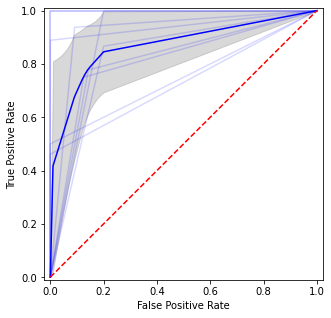

In [74]:
from scipy import interp
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc

tprs = []
base_fpr = np.linspace(0, 1, 101)

plt.figure(figsize=(5, 5))

for i in range(10):
  train_labels = y_train.to_numpy() # train is statified so stratifying on train_labels should be stratified to whole set
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = i, test_size = 0.1, stratify = train_labels)
  
  X_val = X_val.reset_index(drop = True)
  y_val = y_val.reset_index(drop = True)

  clf = SVC(kernel = 'rbf', probability = True, class_weight = 'balanced', C = 100)
  clf.fit(X_train, y_train)

  y_pred = (clf.predict_proba(X_val)[:,1] >= thresh_arr[i]).astype(int) # optimal thresh is 0.59
  curr_acc = accuracy_score(y_val, y_pred)
  print(curr_acc)

  fpr, tpr, _ = roc_curve(y_val, y_pred)
  plt.plot(fpr, tpr, 'b', alpha=0.15)
  tpr = interp(base_fpr, fpr, tpr)
  tpr[0] = 0.0
  tprs.append(tpr)


tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std


plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.show()